# Creating a Prediction Model in PySpark to Predict Environmental Contingencies in the Metropolitan Area of Monterrey, Mexico

*Marco A. García, December 16th, 2024*

In the next notebook, we will explore the creation of Spark contexts and the process of reading data for analysis. We will also analyze the information to discover correlations between features. Finally, we will create a regression model in Spark and evaluate its performance.

The dataset we will use contains the readings of an environmental quality station during the year 2015 in the center of Monterrey city. There is a reading for each hour.

The dataset looks like:

| **Abbreviation** | **Variable**                         | **Units**       |
|-------------------|--------------------------------------|-----------------|
| Date             | Date of the reading                 | -               |
| Month            | Month of the year                   | -               |
| Day              | Day of the month                    | -               |
| DayWeek          | Day of the week in text             | -               |
| Weekday          | Day of the week (Sunday=1)          | -               |
| Hour             | Hour of the day                     | -               |
| CO               | Carbon Monoxide                     | ppm             |
| NO               | Nitric Oxide                        | ppb             |
| NO2              | Nitrogen Dioxide                    | ppb             |
| NOx              | Sum of NO and NO2                   | ppb             |
| O3               | Ozone                                | ppb             |
| PM10             | Particles smaller than 10 microns   | µg/m³           |
| PM2.5            | Particles smaller than 2.5 microns  | µg/m³           |
| PRS              | Pressure                            | mmHg            |
| RAINF            | Rain                                | mm/hr           |
| RH               | Relative Humidity                   | %               |
| SR               | Solar Radiation                     | KW/m²           |
| TOUT             | Temperature                         | °C              |
| WSR              | Wind Speed                          | km/hr           |
| WDV              | Wind Direction                      | °               |


Our principal goal will be to create a model to predict O3 and PM2.5 variables and answer the following questions:

**a. Can we say that O3 or PM2.5 pollution is linked to vehicular traffic?**

**b. Given a weather forecast report provided in the morning, can we predict if there will be an environmental contingency because air pollutants will exceed the limits established by regulations?**

**c. In your own words, what weather conditions must be met to have high levels of O3 pollution? And PM2.5?**

For this exercise, we will build six models in total: three to predict the O3 variable and three models to predict the PM2.5 variable.

Having our goals clear, let's start!

## 1. Install and initialize Spark

The following commands are intended for use on a Unix-based operating system. First, we install JDK headless, a version of the Java Development Kit optimized for command-line environments.

Next, we download Apache Spark from its official distribution directory. Please note that by the time you attempt to execute these commands, there might be changes that result in errors during the download or installation of Spark. If this happens, refer to the [official Apache Spark download page](https://spark.apache.org/downloads.html) for updated instructions.

Finally, after installing both JDK and Spark, we use pip to install findspark, a Python utility that simplifies working with Spark in Python environments.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
!pip install -q findspark

Now that Spark and JDK are installed, we need to set the environment variables to their respective paths. This step ensures that Python can properly locate and execute PySpark.

It is important to note that the paths specified must match the installation locations from the previous steps.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

Finally, we initialize findspark and create a Spark session.

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

We can retrieve the Spark version, which should match the version downloaded in the first step.

In [ ]:
spark.version

'3.5.3'

## 2. Read and select data

We will read the data as a Spark DataFrame to interact with it using Spark.

In [ ]:
path_csv="monterrey-pollution-data.csv"
df = spark.read.csv(path_csv, header=True, inferSchema=True)
df.show(10)

+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|     Date|Month|Day|DayWeek|WeekDay|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+---------+-----+---+-------+-------+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|01-ene-15|    1|  1|    jue|      5|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|01-ene-15|    1|  1|    jue|      5|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|01-ene-15|    1|  1|    jue|      5|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|01-ene-15|    1|  1|    jue|      5|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|01-ene-15|    1|  1|    jue|      5|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|01-ene-15|    1|  1|    jue|      5|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.0

In [ ]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayWeek: string (nullable = true)
 |-- WeekDay: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- CO: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- O3: integer (nullable = true)
 |-- PM10: integer (nullable = true)
 |-- PM2.5: integer (nullable = true)
 |-- PRS: double (nullable = true)
 |-- RAINF: double (nullable = true)
 |-- RH: integer (nullable = true)
 |-- SR: double (nullable = true)
 |-- TOUT: double (nullable = true)
 |-- WSR: double (nullable = true)
 |-- WDV: integer (nullable = true)



As we can see, we have mostly numeric and date-related values. For this example, we won't use date-related values except for the 'Hour' variable.

In [ ]:
df = df.drop("Date", "Month", "Day", "DayWeek", "WeekDay")
df.show(10)

+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|Hour|  CO|  NO| NO2| NOX| O3|PM10|PM2.5|  PRS|RAINF| RH|   SR|TOUT|WSR|WDV|
+----+----+----+----+----+---+----+-----+-----+-----+---+-----+----+---+---+
|   1|2.51|10.2|12.9|23.1| 10| 139|   80|725.4| 0.01| 96|  0.0|3.91|7.2|344|
|   2|2.41| 9.2|11.6|20.8|  7|  42|   29|725.0| 0.02| 96|  0.0|3.81|6.3|341|
|   3|2.39| 8.1|11.8|19.9|  7|  23|    9|724.4|  0.0| 96|  0.0|3.85|5.2|346|
|   5|2.26| 5.3| 8.9|14.2|  7|  23|   14|724.0| 0.01| 96|  0.0|3.79|5.6|336|
|   8|2.25| 7.2|10.2|17.4|  5|  15|    8|724.3|  0.0| 96|0.023|3.93|4.8|354|
|   9|2.21| 5.8| 8.2|14.0|  7|  16|    6|724.3|  0.0| 96|0.052|4.13|4.2| 15|
|  12|2.38|10.0|10.1|20.1| 10|  22|   17|722.6|  0.0| 96|0.127| 6.6|3.2| 29|
|  13|2.51|11.5|12.3|23.8| 12|  32|   16|721.7|  0.0| 95| 0.15|6.89|4.8|  2|
|  14|2.55|12.0|13.5|25.5| 14|  31|   19|721.0|  0.0| 94|0.175|7.43|4.6| 47|
|  15|2.45|10.5|12.8|23.3| 11|  50|   35|720.8|  0.0| 93|0.091|7.15|4.0| 42|

Finally, we will rename 'PM2.5' to 'PM2_5' to avoid conflicts in name referencing.

In [ ]:
df = df.withColumnRenamed("PM2.5", "PM2_5")
df.columns

['Hour',
 'CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'PM10',
 'PM2_5',
 'PRS',
 'RAINF',
 'RH',
 'SR',
 'TOUT',
 'WSR',
 'WDV']

## 3. Data Analysis

Next, we want to determine which variables are correlated with O3 and PM2.5.

To accomplish this, we will use visualization tools to determine which variables to select for building our regression model.

First of all, let's generate a statistical analysis.

In [ ]:
cols = ["CO", "NO", "NO2", "NOX", "O3", "PM10", "PM2_5", "PRS", "RAINF", "RH", "SR", "TOUT", "WSR", "WDV"]

df.describe(cols).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CO,3859,1.8006219227779212,0.8720340991225567,0.29,8.56
NO,3859,13.503653796320318,26.856244699079294,2.3,414.3
NO2,3859,17.539284788381988,13.301006799154928,0.4,99.2
NOX,3859,30.973257321216455,36.090498039388464,3.1,436.0
O3,3859,22.658719875615443,16.51056131885926,2,92
PM10,3859,86.04949468774294,49.00887433131967,8,494
PM2_5,3859,27.675822752008294,16.849434279135153,5,123
PRS,3859,719.629955947137,3.6959485297554657,708.4,734.3
RAINF,3859,0.0026509458406322856,0.04244711534165332,0.0,2.4


As we can see, we don't have any NaN values, which is good.

Next, we notice a lot of standard deviation in many of our variables. Let's list them and analyze if we will plot them:

- NO: Nitric Oxide, we will plot it.
- NO2: Nitric Dioxide, we will plot it.
- NOX: The sum of NO and NO2. We won't plot it because solving NO and NO2 also solves this variable. Moreover, we could use this variable instead of the other two, as it explains them both.
- O3: Ozone, we will plot it.
- PM10: Particles smaller than 10 microns, we will plot it.
- PM2_5: Particles smaller than 2.5 microns, we will plot it.
- RH: Relative Humidity, we will plot it.
- TOUT: Temperature, we won't plot it because its variance throughout the day is normal.
- WSR and WDV: Wind speed and wind direction, same reasoning as TOUT.

Perfect! Let's plot them to discover outliers and anomalies using a boxplot.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True, font_scale=1.0)

We need to convert the Spark DataFrame to an array to plot it. We created the following function to help us with this conversion.

In [ ]:
def spark_col_to_array(df, col):
  col_df = df.select(col)
  rdd = col_df.rdd.map(lambda x: x[col])
  return rdd.collect()

Now, we specify a dictionary where we will store all the transformed information for plotting.

In [ ]:
outlier_values = {
    "NO": spark_col_to_array(df, "NO"),
    "NO2": spark_col_to_array(df, "NO2"),
    "O3": spark_col_to_array(df, "O3"),
    "PM10": spark_col_to_array(df, "PM10"),
    "PM2_5": spark_col_to_array(df, "PM2_5"),
    "RH": spark_col_to_array(df, "RH"),
}

Finally, let's plot them.

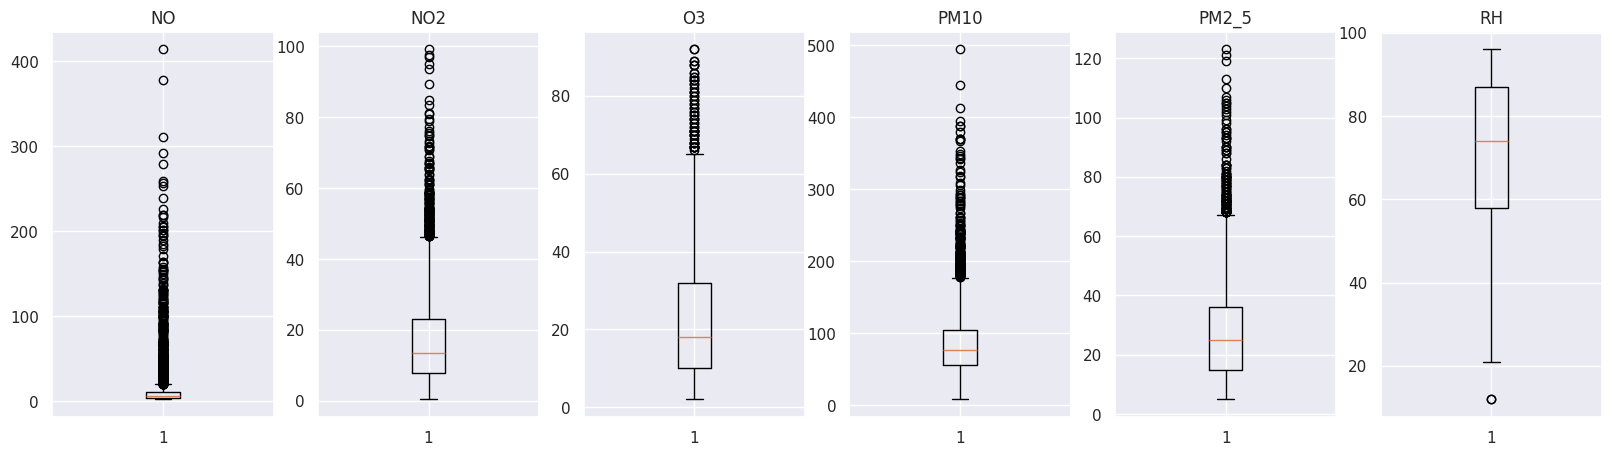

In [ ]:
figure, axs = plt.subplots(1, len(outlier_values), figsize=(20, 5))

i = 0

for k, v in outlier_values.items():
  axs[i].boxplot(v)
  axs[i].set_title(k)
  i = i + 1

Let's also plot an histogram to see the distribution of values.

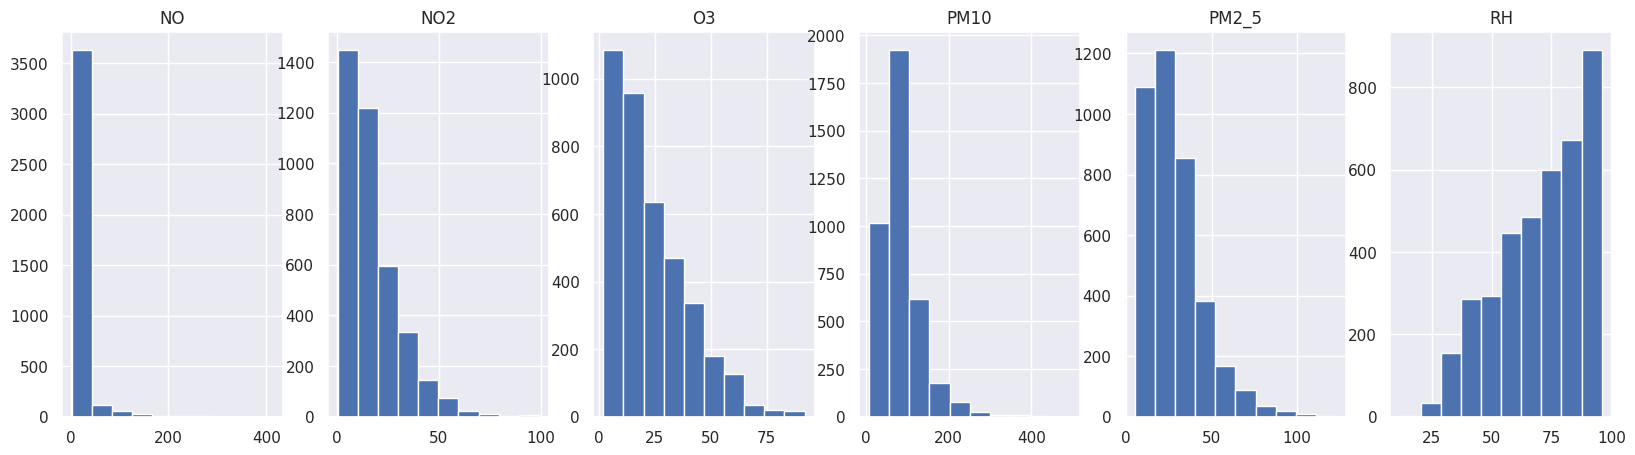

In [ ]:
figure, axs = plt.subplots(1, len(outlier_values), figsize=(20, 5))

i = 0

for k, v in outlier_values.items():
  axs[i].hist(v)
  axs[i].set_title(k)
  i = i + 1

As we can see, we have many extreme values making our data unreadable and incomparable.

We will apply transformations to our variables. Next, we will plot them again, and finally, we will find correlations between them.

To transform our dataset, we will apply a logarithmic transformation.

In [ ]:
import numpy as np

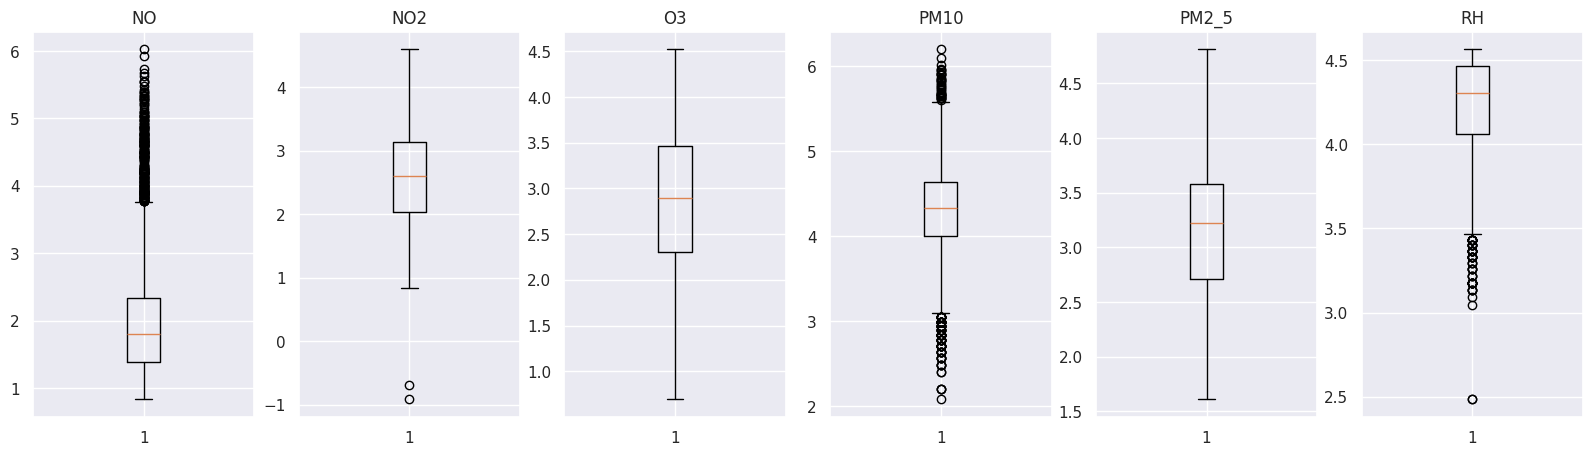

In [ ]:
figure, axs = plt.subplots(1, len(outlier_values), figsize=(20, 5))

i = 0

for k, v in outlier_values.items():
  axs[i].boxplot(np.log(v))
  axs[i].set_title(k)
  i = i + 1

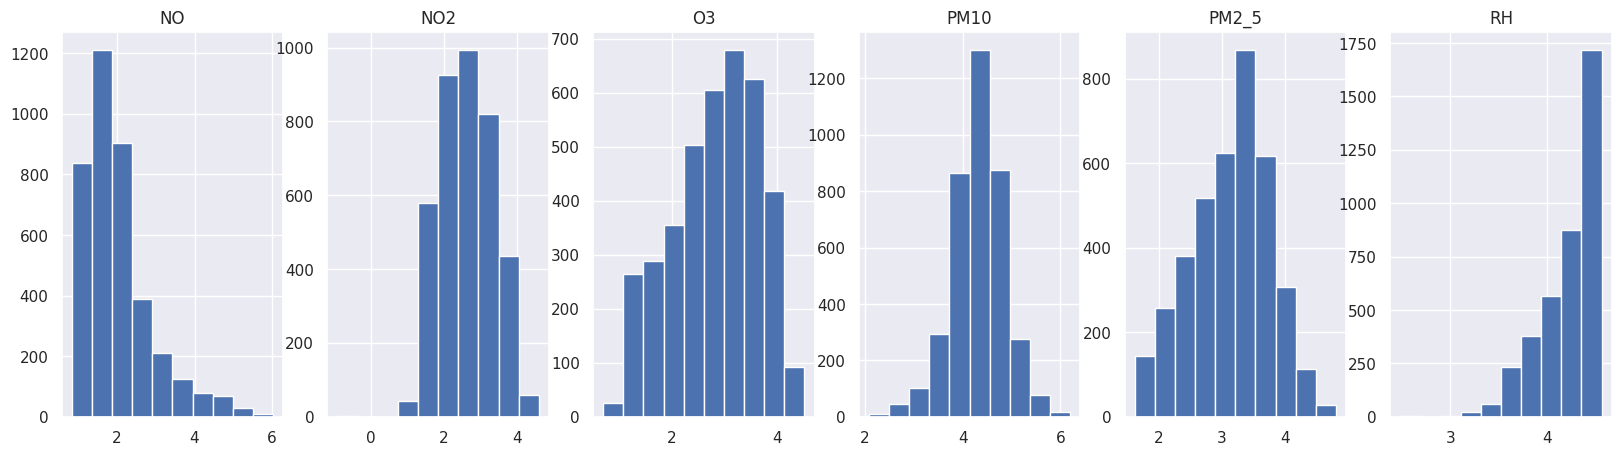

In [ ]:
figure, axs = plt.subplots(1, len(outlier_values), figsize=(20, 5))

i = 0

for k, v in outlier_values.items():
  axs[i].hist(np.log(v))
  axs[i].set_title(k)
  i = i + 1

Perfect! Now we can see a better distribution in our data.

Finally, I want to calculate the correlation between my variables to determine which ones I can use to build the regression model.

For now, let's focus on calculating the correlations of transformed variables and selecting the X variables for the model.

To calculate correlation in Spark, we need to transform our dataset into a Spark Vector Assembler.

In [ ]:
from pyspark.sql import functions as F

df_log = df

cols_to_transform = df.columns

for col in cols_to_transform:
    df_log = df_log.withColumn(col, F.log(F.col(col) + 1))

df_log.show(1)

+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+-----------------+---+------------------+------------------+----------------+
|              Hour|                CO|                NO|              NO2|               NOX|                O3|             PM10|            PM2_5|              PRS|               RAINF|               RH| SR|              TOUT|               WSR|             WDV|
+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+--------------------+-----------------+---+------------------+------------------+----------------+
|0.6931471805599453|1.2556160374777745|2.4159137783010487|2.631888840136646|3.1822118404966093|2.3978952727983707|4.941642422609304|4.394449154672439|6.588100827287083|0.009950330853168092|4.57471097

In [ ]:
from pyspark.ml.feature import VectorAssembler

vector_col = "features"

assembler = VectorAssembler(inputCols=df_log.columns, outputCol=vector_col)

df_vector = assembler.transform(df_log).select(vector_col)

df_vector.show(10)

+--------------------+
|            features|
+--------------------+
|[0.69314718055994...|
|[1.09861228866810...|
|[1.38629436111989...|
|[1.79175946922805...|
|[2.19722457733621...|
|[2.30258509299404...|
|[2.56494935746153...|
|[2.63905732961525...|
|[2.70805020110221...|
|[2.77258872223978...|
+--------------------+
only showing top 10 rows



Now we have a Vector Assembler, we can calculate correlations.

We will use Pearson and Spearman correlation.

In [ ]:
from pyspark.ml.stat import Correlation

pearson_corr = Correlation.corr(df_vector, vector_col, "pearson")
spearman_corr = Correlation.corr(df_vector, vector_col, "spearman")

Now, with the correlations calculated, we can transform them into a NumPy array and plot them.

In [ ]:
pearson_corr_arr = np.matrix(pearson_corr.collect()[0]["pearson({})".format(vector_col)].values).reshape(len(df_log.columns), len(df_log.columns))

spearman_corr_arr = np.matrix(spearman_corr.collect()[0]["spearman({})".format(vector_col)].values).reshape(len(df_log.columns), len(df_log.columns))

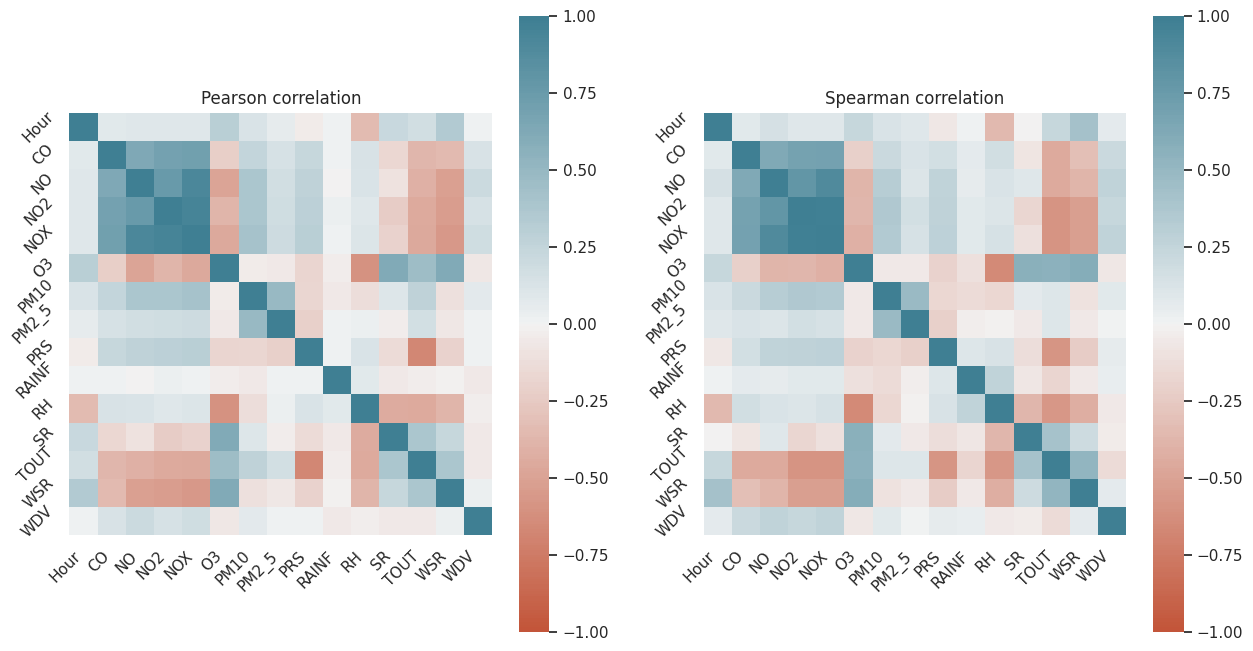

In [ ]:
figure, axs = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(
    pearson_corr_arr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=axs[0]
)

sns.heatmap(
    spearman_corr_arr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=axs[1]
)

axs[0].set_title("Pearson correlation")
axs[1].set_title("Spearman correlation")

for ax in axs:
  ax.set_xticklabels(
      df_log.columns,
      rotation=45,
      horizontalalignment="right"
  )

  ax.set_yticklabels(
      df_log.columns,
      rotation=45,
      horizontalalignment="right"
  )

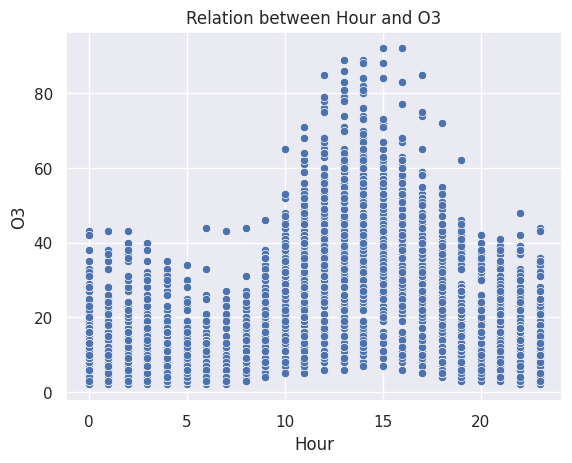

In [ ]:
pandas_df_scatter = df.toPandas()

ax = sns.scatterplot(pandas_df_scatter, x=pandas_df_scatter["Hour"], y=pandas_df_scatter["O3"])

ax.set_title("Relation between Hour and O3")

plt.show()

Excellent! Having these plots, we can start making decisions.

The variables we will take are those most correlated with O3 and PM2_5 (our Y variables).

For this exercise, we will use the following variables for each prediction:
- O3: Hour, RH, SR, and WSR
- PM2_5: PM10

## 4. Building Regression Models

We will create two Vector Assemblers (one for each Y variable) based on the transformed DataFrame.

In [ ]:
assembler_o3 = VectorAssembler(inputCols=["Hour", "RH", "SR", "WSR"], outputCol="X")
output_o3 = assembler_o3.transform(df_log)
vector_o3 = output_o3.select("X", "O3")
vector_o3.show(10)

+--------------------+------------------+
|                   X|                O3|
+--------------------+------------------+
|[0.69314718055994...|2.3978952727983707|
|[1.09861228866810...|2.0794415416798357|
|[1.38629436111989...|2.0794415416798357|
|[1.79175946922805...|2.0794415416798357|
|[2.19722457733621...| 1.791759469228055|
|[2.30258509299404...|2.0794415416798357|
|[2.56494935746153...|2.3978952727983707|
|[2.63905732961525...|2.5649493574615367|
|[2.70805020110221...|  2.70805020110221|
|[2.77258872223978...|2.4849066497880004|
+--------------------+------------------+
only showing top 10 rows



In [ ]:
assembler_pm2_5 = VectorAssembler(inputCols=["PM10"], outputCol="X")
output_pm2_5 = assembler_pm2_5.transform(df_log)
vector_pm2_5 = output_pm2_5.select("X", "PM2_5")
vector_pm2_5.show(10)

+--------------------+------------------+
|                   X|             PM2_5|
+--------------------+------------------+
| [4.941642422609304]| 4.394449154672439|
|[3.7612001156935624]|3.4011973816621555|
|[3.1780538303479458]| 2.302585092994046|
|[3.1780538303479458]|  2.70805020110221|
| [2.772588722239781]|2.1972245773362196|
| [2.833213344056216]|1.9459101490553132|
|[3.1354942159291497]|2.8903717578961645|
|[3.4965075614664802]| 2.833213344056216|
|[3.4657359027997265]| 2.995732273553991|
|[3.9318256327243257]|  3.58351893845611|
+--------------------+------------------+
only showing top 10 rows



Nice! Our next step is to split our dataset into training and test datasets.

In this case, we will split it into 80% for training and 20% for testing.

In [ ]:
train_o3, test_o3 = vector_o3.randomSplit([0.8, 0.2])

train_pm2_5, test_pm2_5 = vector_pm2_5.randomSplit([0.8, 0.2])

Perfect! We now have datasets to start creating models.

In this case, we will create three models for each Y variable, and at the end, we will select the most suitable model for each Y variable based on evaluation metrics.

The models we will use are Linear Regression, Random Forest Regressor, and Gradient-Boosted Trees Regressor.

In [ ]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor

In [ ]:
lr_o3 = LinearRegression(featuresCol="X", labelCol="O3")
lr_o3 = lr_o3.fit(train_o3)
pred_lr_o3 = lr_o3.evaluate(test_o3)
pred_lr_o3.predictions.show(1)

rfr_o3 = RandomForestRegressor(featuresCol="X", labelCol="O3")
rfr_o3 = rfr_o3.fit(train_o3)
pred_rfr_o3 = rfr_o3.transform(test_o3)
pred_rfr_o3.show(1)

gbtr_o3 = GBTRegressor(featuresCol="X", labelCol="O3")
gbtr_o3 = gbtr_o3.fit(train_o3)
pred_gbtr_o3 = gbtr_o3.transform(test_o3)
pred_gbtr_o3.show(1)

+--------------------+-----------------+-----------------+
|                   X|               O3|       prediction|
+--------------------+-----------------+-----------------+
|[0.0,3.6635616461...|3.332204510175204|3.335264203024247|
+--------------------+-----------------+-----------------+
only showing top 1 row

+--------------------+-----------------+------------------+
|                   X|               O3|        prediction|
+--------------------+-----------------+------------------+
|[0.0,3.6635616461...|3.332204510175204|3.2050697408843485|
+--------------------+-----------------+------------------+
only showing top 1 row

+--------------------+-----------------+------------------+
|                   X|               O3|        prediction|
+--------------------+-----------------+------------------+
|[0.0,3.6635616461...|3.332204510175204|3.5337298981433842|
+--------------------+-----------------+------------------+
only showing top 1 row



In [ ]:
lr_pm2_5 = LinearRegression(featuresCol="X", labelCol="PM2_5")
lr_pm2_5 = lr_pm2_5.fit(train_pm2_5)
pred_lr_pm2_5 = lr_pm2_5.evaluate(test_pm2_5)
pred_lr_pm2_5.predictions.show(1)

rfr_pm2_5 = RandomForestRegressor(featuresCol="X", labelCol="PM2_5")
rfr_pm2_5 = rfr_pm2_5.fit(train_pm2_5)
pred_rfr_pm2_5 = rfr_pm2_5.transform(test_pm2_5)
pred_rfr_pm2_5.show(1)

gbtr_pm2_5 = GBTRegressor(featuresCol="X", labelCol="PM2_5")
gbtr_pm2_5 = gbtr_pm2_5.fit(train_pm2_5)
pred_gbtr_pm2_5 = gbtr_pm2_5.transform(test_pm2_5)
pred_gbtr_pm2_5.show(1)

+--------------------+-----------------+-----------------+
|                   X|            PM2_5|       prediction|
+--------------------+-----------------+-----------------+
|[2.4849066497880004]|2.302585092994046|2.134835413092529|
+--------------------+-----------------+-----------------+
only showing top 1 row

+--------------------+-----------------+------------------+
|                   X|            PM2_5|        prediction|
+--------------------+-----------------+------------------+
|[2.4849066497880004]|2.302585092994046|2.3809729389424974|
+--------------------+-----------------+------------------+
only showing top 1 row

+--------------------+-----------------+-----------------+
|                   X|            PM2_5|       prediction|
+--------------------+-----------------+-----------------+
|[2.4849066497880004]|2.302585092994046|2.382399554713545|
+--------------------+-----------------+-----------------+
only showing top 1 row



## 5. Evaluating Regression Models

We are in the final steps. The last thing we will do is evaluate our models using metrics like RMSE, MSE, MAE, and R2.

After evaluating the models, we will select the best ones and use the predictions to answer the initial questions.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def eval_model_predictions(pred, labelCol, predictionCol = "prediction"):
  evaluator = RegressionEvaluator(labelCol=labelCol, predictionCol=predictionCol)
  rmse = evaluator.evaluate(pred)
  mse = evaluator.evaluate(pred, { evaluator.metricName: "mse" })
  mae = evaluator.evaluate(pred, { evaluator.metricName: "mae" })
  r2 = evaluator.evaluate(pred, { evaluator.metricName: "r2" })

  return {
      "RMSE": rmse,
      "MSE": mse,
      "MAE": mae,
      "R2": r2
  }

In [ ]:
evaluations_lr_o3 = eval_model_predictions(pred_lr_o3.predictions, "O3")
evaluations_rfr_o3 = eval_model_predictions(pred_rfr_o3, "O3")
evaluations_gbtr_o3 = eval_model_predictions(pred_gbtr_o3, "O3")

evaluations_lr_pm2_5 = eval_model_predictions(pred_lr_pm2_5.predictions, "PM2_5")
evaluations_rfr_pm2_5 = eval_model_predictions(pred_rfr_pm2_5, "PM2_5")
evaluations_gbtr_pm2_5 = eval_model_predictions(pred_gbtr_pm2_5, "PM2_5")

Now that we have the metrics, let's plot them to see which model is the best.

In [ ]:
evaluations_o3 = {
    "RMSE": (evaluations_lr_o3["RMSE"], evaluations_rfr_o3["RMSE"], evaluations_gbtr_o3["RMSE"]),
    "MSE": (evaluations_lr_o3["MSE"], evaluations_rfr_o3["MSE"], evaluations_gbtr_o3["MSE"]),
    "MAE": (evaluations_lr_o3["MAE"], evaluations_rfr_o3["MAE"], evaluations_gbtr_o3["MAE"]),
    "R2": (evaluations_lr_o3["R2"], evaluations_rfr_o3["R2"], evaluations_gbtr_o3["R2"])
}

evaluations_pm2_5 = {
    "RMSE": (evaluations_lr_pm2_5["RMSE"], evaluations_rfr_pm2_5["RMSE"], evaluations_gbtr_pm2_5["RMSE"]),
    "MSE": (evaluations_lr_pm2_5["MSE"], evaluations_rfr_pm2_5["MSE"], evaluations_gbtr_pm2_5["MSE"]),
    "MAE": (evaluations_lr_pm2_5["MAE"], evaluations_rfr_pm2_5["MAE"], evaluations_gbtr_pm2_5["MAE"]),
    "R2": (evaluations_lr_pm2_5["R2"], evaluations_rfr_pm2_5["R2"], evaluations_gbtr_pm2_5["R2"])
}

In [ ]:
def plot_evaluations(evaluations, title):
  models = ["Linear Regression", "Random Forest Regressor", "GBT Regressor"]

  x = np.arange(len(models))
  width = 0.25
  multiplier = 0

  min_value = 0
  max_value = 0

  fig, ax = plt.subplots(figsize=(10, 5))

  for metric, values in evaluations.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=metric)
    ax.bar_label(rects, labels=[f'{v:,.4f}' for v in values], padding=3)
    multiplier += 1
    min_value = min(values) if min(values) < min_value else min_value
    max_value = max(values) if max(values) > max_value else max_value

  ax.set_ylabel("Values")
  ax.set_title(title)
  ax.set_xticks(x + width, models)
  ax.legend(loc='upper left', ncols=4)
  ax.set_ylim(min_value, max_value + (max_value / 100) * 20)
  plt.show()

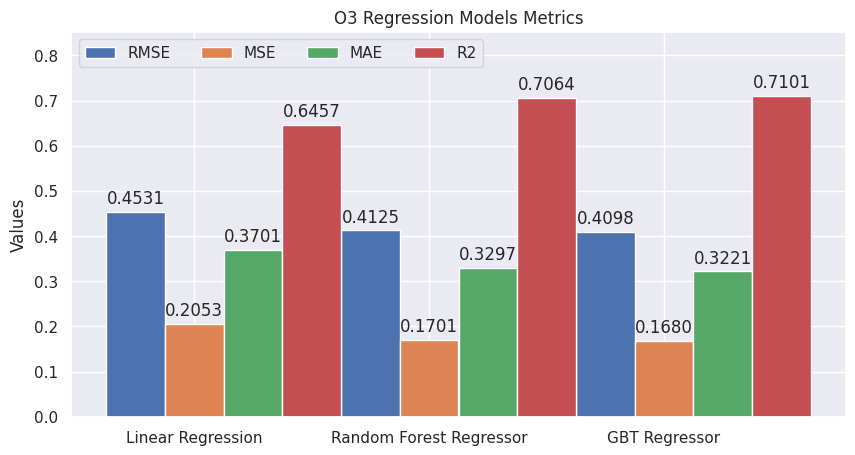

In [ ]:
plot_evaluations(evaluations_o3, "O3 Regression Models Metrics")

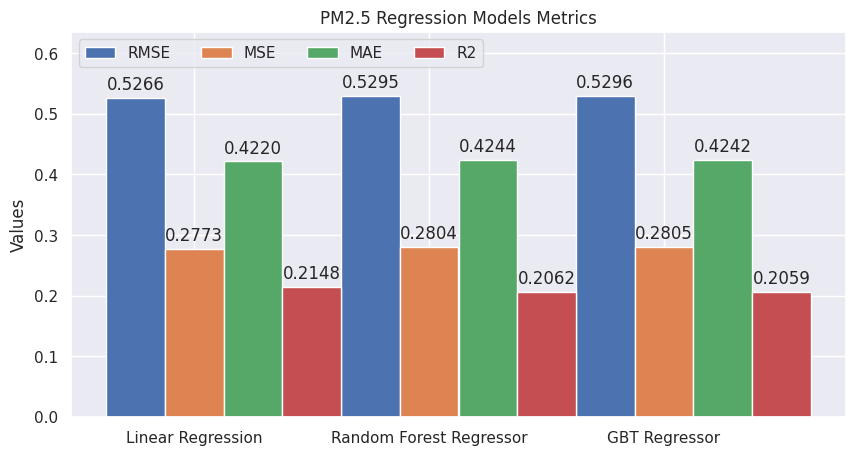

In [ ]:
plot_evaluations(evaluations_pm2_5, "PM2.5 Regression Models Metrics")

At this point, we can start making decisions.

According to the charts, the GBT Regressor is the best model to predict the O3 variable.

On the other hand, Linear Regression has better metrics compared to the other models for predicting the PM2.5 variable.

If we want to increase the success of the models we should conduct further analysis of the nature of the data and improve our understanding of the domain.

## 6. Answering questions

Now we have enough information to start answering the initial questions.

**a. Can we say that O3 or PM2.5 pollution is linked to vehicular traffic?**

According to the correlation plots, we find that there is a relationship between Hour and O3. O3 levels increase between 10:00 and 19:00, reaching a maximum point at 15:00. These times align with the hours of peak traffic in the city. In conclusion, yes, there is a link between O3 pollution and vehicular traffic.

**b. Given a weather forecast report provided in the morning, can we predict if there will be an environmental contingency because air pollutants will exceed the limits established by regulations?**

Yes, with the models we have built, trained, and evaluated, we are capable of predicting if there will be an environmental contingency, provided the weather forecast contains our X variables.

**c. In your own words, what weather conditions must be met to have high levels of O3 pollution? And PM2.5?**

The weather conditions that must be met to have high levels of O3 pollution include high WSR, TOUT, and SR, as well as an hour between 10:00 and 19:00.

On the other hand, the weather conditions that must be met to have high levels of PM2.5 include a high level of PM10.

## 7. Final Thoughts

During this project, we successfully performed data reading and manipulation using PySpark. We conducted an exploratory analysis to uncover relationships between variables that could aid in building a regression model. Ultimately, we constructed six regression models, which were evaluated using four widely recognized metrics, allowing us to select the most suitable model for each scenario.

This comprehensive process enabled us to answer the initial questions posed at the start of the project. Additionally, we now have a robust tool that allows us to predict O3 and PM2.5 levels with confidence, contributing to better understanding and potential mitigation of air pollution in urban areas.